<a href="https://colab.research.google.com/github/Dedalus1982/MIPHI_Kurs_Classik_ML/blob/main/Kurs_classic_DAF_CC50_class2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка и подготовка данных:

In [10]:
!pip install catboost -q
!pip install optuna -q

In [11]:
# Подключение к Google Drive и работа с файлами
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour

# Статистические методы
from scipy.stats import mannwhitneyu

# Машинное обучение
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Регрессоры
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                             GradientBoostingClassifier, HistGradientBoostingClassifier)
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Метрики
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report)

import joblib
from pickle import TRUE
import os
import optuna

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'
handmade = pd.read_csv(os.path.join(data_dir,'df_handmade.csv')).drop(columns=['SI', 'IC50'])
pca = pd.read_csv(os.path.join(data_dir,'pca_cleaned_CC50.csv'))
tsne = pd.read_csv(os.path.join(data_dir,'tsne_cleaned_CC50.csv'))
umap = pd.read_csv(os.path.join(data_dir,'umap_cleaned_CC50.csv'))

In [13]:
# @title Подготовка данных для моделирования
analyse_name = 'class2'
base_parameter = 'CC50'

metod_name_1 = 'handmade'
df_1 = handmade

metod_name_2 = 'pca'
df_2 = pca

metod_name_3 = 'tsne'
df_3 = tsne

metod_name_4 = 'umap'
df_4 = umap

# название файла с хранением всех результатов
csv_file_final = f"{analyse_name}_{base_parameter}.csv"

# МОДЕЛИРОВАНИЕ

In [18]:
# @title класс ClassificationModelEvaluator для анализа моделей
class ClassificationModelEvaluator:
    def __init__(self, df, base_parameter='IC50', test_size=0.2, random_state=42,
                 models_config=None, metod_name="", analyse_name="class", data_dir=None):
        self.base_parameter = base_parameter
        self.test_size = test_size
        self.random_state = random_state
        self.models = {}
        self.results = None
        self.best_model = None
        self.metod_name = metod_name
        self.analyse_name = analyse_name
        self.grid_search_results = {}
        self.data_dir = data_dir or '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'

        # делим исходный DF на X и y
        X = df.drop(columns=[base_parameter])
        y = df[base_parameter]
        self.X = X
        self.y = y
        # бинарный таргет для стратификации (прочитал, что утечка не будет сильной)
        y_for_stratify = (y > y.median()).astype(int)
        # train_test_split
        self.X_train, self.X_test, self.y_train_reg, self.y_test_reg = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y_for_stratify
        )
        # медиана только по train
        self.train_median = self.y_train_reg.median()
        # бинарные таргеты для train и test по train-медиане
        self.y_train = (self.y_train_reg > self.train_median).astype(int)
        self.y_test  = (self.y_test_reg  > self.train_median).astype(int)

        # конструктор файлов
        self.base_name = f"{self.base_parameter}_{self.analyse_name}_{self.metod_name}"
        self.table_name = f"table_{self.base_name}.csv"
        self.final_name = f"{self.base_name}_"

        # конструктор моделей
        if models_config is None:
            self.models = self.create_models_config()
        else:
            self.models = models_config

    def create_models_config(self):
        models_config = {
            'LogisticRegression': {
                'model': make_pipeline(
                    StandardScaler(),
                    LogisticRegression(max_iter=2000)
                ),
                'params': {
                    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                    'logisticregression__penalty': ['l2'],
                    'logisticregression__solver': ['lbfgs', 'liblinear', 'saga']
                }
            },
            'SVC': {
                'model': make_pipeline(
                    StandardScaler(),
                    SVC(probability=True)
                ),
                'params': {
                    'svc__C': [0.1, 1, 10],
                    'svc__kernel': ['linear', 'rbf'],
                    'svc__gamma': ['scale', 'auto']
                }
            },
            'KNN': {
                'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsClassifier()
                ),
                'params': {
                    'kneighborsclassifier__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                    'kneighborsclassifier__weights': ['uniform', 'distance'],
                    'kneighborsclassifier__p': [1, 2]
                }
            },
            'DecisionTree': {
                'model': DecisionTreeClassifier(random_state=self.random_state),
                'params': {
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'RandomForest': {
                'model': RandomForestClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'max_features': ['sqrt', 'log2']
                }
            },
            'ExtraTrees': {
                'model': ExtraTreesClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'GradientBoosting': {
                'model': GradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'min_samples_split': [2, 5, 10]
                }
            },
            'HistGradientBoosting': {
                'model': HistGradientBoostingClassifier(random_state=self.random_state),
                'params': {
                    'max_iter': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'min_samples_leaf': [10, 20]
                }
            },
            'XGBoost': {
                'model': XGBClassifier(random_state=self.random_state, eval_metric='logloss'),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10, 20, 30],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost': {
                'model': CatBoostClassifier(random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'depth': [3, 5, 7, 10],
                    'l2_leaf_reg': [3, 5]
                }
            }
        }
        return models_config

    def evaluate_models(self, verbose=False, auto_save_metrics=True):
        results = []
        self.grid_search_results = {}

        for name, model_info in self.models.items():
            if verbose:
            #    print(f"\n{'='*50}")
                print(f"Подбор параметров {name}...")

            model = model_info['model']
            params = model_info['params']

            # подбор параметров через GridSearchCV
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.random_state)
            # loo = LeaveOneOut()
            gs = GridSearchCV(
                model,
                params,
                cv=skf,
                scoring='roc_auc',
                n_jobs=-1,
                verbose=1 if verbose else 0
            )
            gs.fit(self.X_train, self.y_train)
            self.grid_search_results[name] = gs  # сохраняем GridSearchCV объект

            # лучшая модель
            best_model = gs.best_estimator_
            best_params = gs.best_params_
            cv_score = gs.best_score_

            # if verbose:
            #    print(f"Best params: {best_params}")

            # предсказания на тестовом наборе
            y_pred = best_model.predict(self.X_test)
            y_proba = best_model.predict_proba(self.X_test)[:, 1]
            # метрики
            metrics = {
                'Model': name,
                'Metod': self.metod_name,
                'Best Parameters': best_params,
                'CV ROC AUC': cv_score,
                'Test Accuracy': accuracy_score(self.y_test, y_pred),
                'Test Precision': precision_score(self.y_test, y_pred),
                'Test Recall': recall_score(self.y_test, y_pred),
                'Test F1': f1_score(self.y_test, y_pred),
                'Test ROC AUC': roc_auc_score(self.y_test, y_proba),
                'Confusion Matrix': confusion_matrix(self.y_test, y_pred),
                'Classification Report': classification_report(self.y_test, y_pred, output_dict=True)
            }
            results.append(metrics)
            if verbose:
                print(f"выполнено: Test ROC AUC: {metrics['Test ROC AUC']:.3f}")
            # лучшая модель
            if self.best_model is None or metrics['Test ROC AUC'] > self.best_model[1]:
                self.best_model = (best_model, metrics['Test ROC AUC'])
        # результаты
        self.results = pd.DataFrame(results)
        self.results.set_index('Model', inplace=True)
        self.results = self.results.sort_values('Test ROC AUC', ascending=False)
        # сохранение метрик
        if auto_save_metrics:
            self._save_all_models_metrics()
        return self.results

    def _save_all_models_metrics(self):
        if self.results is None:
            raise ValueError("Нет результатов для сохранения")
        os.makedirs(self.data_dir, exist_ok=True)
        filepath = os.path.join(self.data_dir, self.table_name)
        save_df = self.results.copy()
        save_df.to_csv(filepath)
        print(f"Метрики всех моделей сохранены в {filepath}")
        return filepath

    def get_top_models(self, n=3):
        if self.results is None:
            raise ValueError("Сначала evaluate_models()")
        y_binary = (self.y > self.train_median).astype(int)

        top_models = []
        for model_name in self.results.index[:n]:
            # забираем модель из GridSearchCV
            gs = self.grid_search_results[model_name]
            best_model = gs.best_estimator_
            # обучаем на всём датасете
            final_model = clone(best_model)
            final_model.fit(self.X, y_binary)
            # вычисляем метрики
            metrics = self.results.loc[model_name].to_dict()

            top_models.append({
                'name': model_name,
                'model': final_model,
                'metrics': metrics
            })

        return top_models

    def save_top_models(self, n=3):
        if self.results is None:
            raise ValueError("Сначала evaluate_models()")

        os.makedirs(self.data_dir, exist_ok=True)
        top_models = self.get_top_models(n)
        prefix=self.final_name
        # сохраняем модели
        saved_files = []
        for model_info in top_models:
            filename = f"{prefix}{model_info['name'].lower().replace(' ', '_')}.pkl"
            filepath = os.path.join(self.data_dir, filename)

            joblib.dump(model_info['model'], filepath)
            saved_files.append(filepath)
            print(f"Модель {model_info['name']} сохранена в {filepath}")
        # сохраняем метрики
        metrics_filename = f"{prefix}metrics.csv"
        metrics_filepath = os.path.join(self.data_dir, metrics_filename)
        # создаем DF с метриками
        metrics_data = []
        for model_info in top_models:
            metrics = model_info['metrics']
            metrics.pop('Best Parameters', None)
            metrics.pop('Confusion Matrix', None)
            metrics.pop('Classification Report', None)
            metrics_data.append(metrics)

        metrics_df = pd.DataFrame(metrics_data)
        metrics_df.to_csv(metrics_filepath, index=False)
        print(f"Метрики топ-{n} моделей сохранены в {metrics_filepath}")

        return {
            'model_files': saved_files,
            'metrics_file': metrics_filepath
        }

    def predict(self, X, return_proba=False):
        if self.best_model is None:
            raise ValueError("Сначала evaluate_models()")
        if return_proba:
            return self.best_model[0].predict_proba(X)
        return self.best_model[0].predict(X)

In [15]:
# @title Класс ClassificationResultsVisualizer для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import numpy as np

class ClassificationResultsVisualizer:
    def __init__(self, evaluator, results_df):
        self.evaluator = evaluator
        self.results_df = results_df
        self.best_model_name = results_df.index[0]

        # Настройка стиля графиков
        sns.set_style("whitegrid")
        self.colors = sns.color_palette("husl")
        plt.rcParams['figure.facecolor'] = 'white'

    def plot_metrics_comparison(self, metrics=None, ax=None):
        if metrics is None:
            metrics = ['Test ROC AUC', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']

        plot_df = self.results_df[metrics].sort_values(metrics[0], ascending=True)
        colors = self.colors[:len(metrics)]
        plot_df.plot(kind='barh', width=0.8, color=colors, ax=ax, legend=False)    # выключили легенду

        ax.set_title('Сравнение метрик', fontsize=13)
        ax.set_xlabel('Значение метрики', fontsize=11)
        ax.set_ylabel('Модель', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(metrics, loc='lower right', fontsize=8)

    def plot_roc_curves(self, top_n=10, ax=None):
        for i, model_name in enumerate(self.results_df.index[:top_n]):
            roc_auc = self.results_df.loc[model_name, 'Test ROC AUC']
            model_info = self.evaluator.models[model_name]
            model = model_info['model'].fit(self.evaluator.X_train, self.evaluator.y_train)
            y_proba = model.predict_proba(self.evaluator.X_test)[:, 1]
            fpr, tpr, _ = roc_curve(self.evaluator.y_test, y_proba)
            ax.plot(fpr, tpr, lw=2,
                    label=f'{model_name} (AUC = {roc_auc:.2f})',
                    color=self.colors[i % len(self.colors)])
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=11)
        ax.set_ylabel('True Positive Rate', fontsize=11)
        ax.set_title(f'ROC-кривые топ-{top_n} моделей', fontsize=13)
        ax.legend(loc="lower right", fontsize=8)
        ax.grid(True, alpha=0.3)

    def plot_confusion_matrix(self, ax=None):
        best_model_pred = self.evaluator.predict(self.evaluator.X_test)
        cm = confusion_matrix(self.evaluator.y_test, best_model_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Низкий IC50', 'Высокий IC50'],
                    yticklabels=['Низкий IC50', 'Высокий IC50'],
                    ax=ax)
        ax.set_title(f'Матрица ошибок ({self.best_model_name})', fontsize=13)
        ax.set_ylabel('Истинный класс', fontsize=11)
        ax.set_xlabel('Предсказанный класс', fontsize=11)

    def plot_precision_recall_curve(self, ax=None):
        y_proba = self.evaluator.predict(self.evaluator.X_test, return_proba=True)[:, 1]
        precision, recall, _ = precision_recall_curve(self.evaluator.y_test, y_proba)
        average_precision = average_precision_score(self.evaluator.y_test, y_proba)

        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))

        ax.plot(recall, precision, label=f'AP={average_precision:.2f}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve')
        ax.legend()
        return ax

    def visualize_all(self):
        # 2 строки, 2 столбца
        fig, axes = plt.subplots(2, 2, figsize=(17, 13))
        plt.subplots_adjust(hspace=0.3, wspace=0.2)

        self.plot_metrics_comparison(ax=axes[0, 0])
        self.plot_roc_curves(ax=axes[0, 1])
        self.plot_confusion_matrix(ax=axes[1, 0])
        self.plot_precision_recall_curve(ax=axes[1, 1])

        plt.show()


Подбор параметров LogisticRegression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
выполнено: Test ROC AUC: 0.781
Подбор параметров SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
выполнено: Test ROC AUC: 0.794
Подбор параметров KNN...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
выполнено: Test ROC AUC: 0.770
Подбор параметров DecisionTree...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.683
Подбор параметров RandomForest...
Fitting 3 folds for each of 126 candidates, totalling 378 fits
выполнено: Test ROC AUC: 0.809
Подбор параметров ExtraTrees...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.781
Подбор параметров GradientBoosting...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
выполнено: Test ROC AUC: 0.766
Подбор параметров HistGradientBoosting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
выполнено: Test 

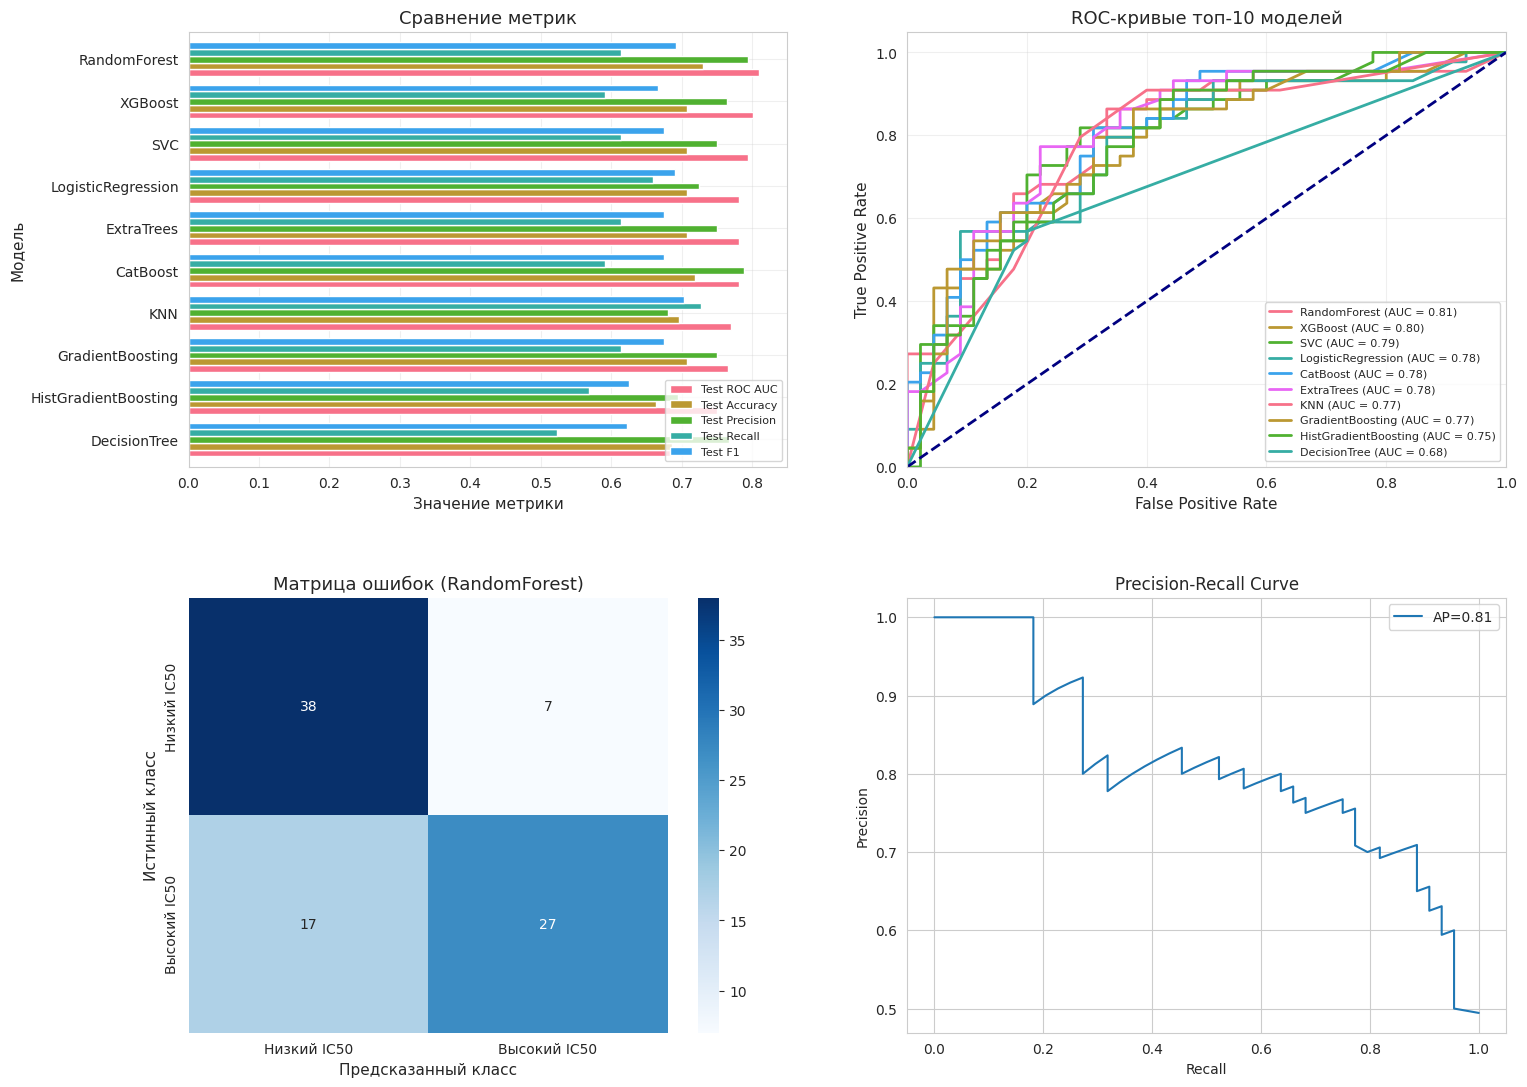

Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_handmade_randomforest.pkl
Модель XGBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_handmade_xgboost.pkl
Модель SVC сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_handmade_svc.pkl
Модель LogisticRegression сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_handmade_logisticregression.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_handmade_catboost.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_handmade_metrics.csv


In [19]:
# @title Тест моделей на ручных данных
# инициализация
evaluator_1 = ClassificationModelEvaluator(                     # ПОМЕНЯТЬ ТУТ!
    df=df_1,                                                    # ПОМЕНЯТЬ ТУТ!
    base_parameter=base_parameter,
    metod_name=metod_name_1,                                    # ПОМЕНЯТЬ ТУТ!
    analyse_name=analyse_name
    )
results = evaluator_1.evaluate_models(verbose=True)             # ПОМЕНЯТЬ ТУТ!
results_1 = results.copy()                                      # ПОМЕНЯТЬ ТУТ!

# Диаграмки
visualizer = ClassificationResultsVisualizer(
    evaluator_1,                                                # ПОМЕНЯТЬ ТУТ!
    results_df = results_1                                      # ПОМЕНЯТЬ ТУТ!
    )
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_1.save_top_models(n=5)                  # ПОМЕНЯТЬ ТУТ!

In [20]:
results_1.head(5)

,Metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,
RandomForest,handmade,"{'max_depth': None, 'max_features': 'log2', 'm...",0.803383,0.730337,0.794118,0.613636,0.692308,0.809343,"[[38, 7], [17, 27]]","{'0': {'precision': 0.6909090909090909, 'recal..."
XGBoost,handmade,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.795497,0.707865,0.764706,0.590909,0.666667,0.800758,"[[37, 8], [18, 26]]","{'0': {'precision': 0.6727272727272727, 'recal..."
SVC,handmade,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",0.756430,0.707865,0.750000,0.613636,0.675000,0.794192,"[[36, 9], [17, 27]]","{'0': {'precision': 0.6792452830188679, 'recal..."
LogisticRegression,handmade,"{'logisticregression__C': 0.01, 'logisticregre...",0.708496,0.707865,0.725000,0.659091,0.690476,0.781061,"[[34, 11], [15, 29]]","{'0': {'precision': 0.6938775510204082, 'recal..."
CatBoost,handmade,"{'depth': 3, 'iterations': 100, 'l2_leaf_reg':...",0.801104,0.719101,0.787879,0.590909,0.675325,0.781061,"[[38, 7], [18, 26]]","{'0': {'precision': 0.6785714285714286, 'recal..."


Подбор параметров LogisticRegression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
выполнено: Test ROC AUC: 0.752
Подбор параметров SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
выполнено: Test ROC AUC: 0.825
Подбор параметров KNN...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
выполнено: Test ROC AUC: 0.816
Подбор параметров DecisionTree...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.706
Подбор параметров RandomForest...
Fitting 3 folds for each of 126 candidates, totalling 378 fits
выполнено: Test ROC AUC: 0.793
Подбор параметров ExtraTrees...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.823
Подбор параметров GradientBoosting...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
выполнено: Test ROC AUC: 0.815
Подбор параметров HistGradientBoosting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
выполнено: Test 

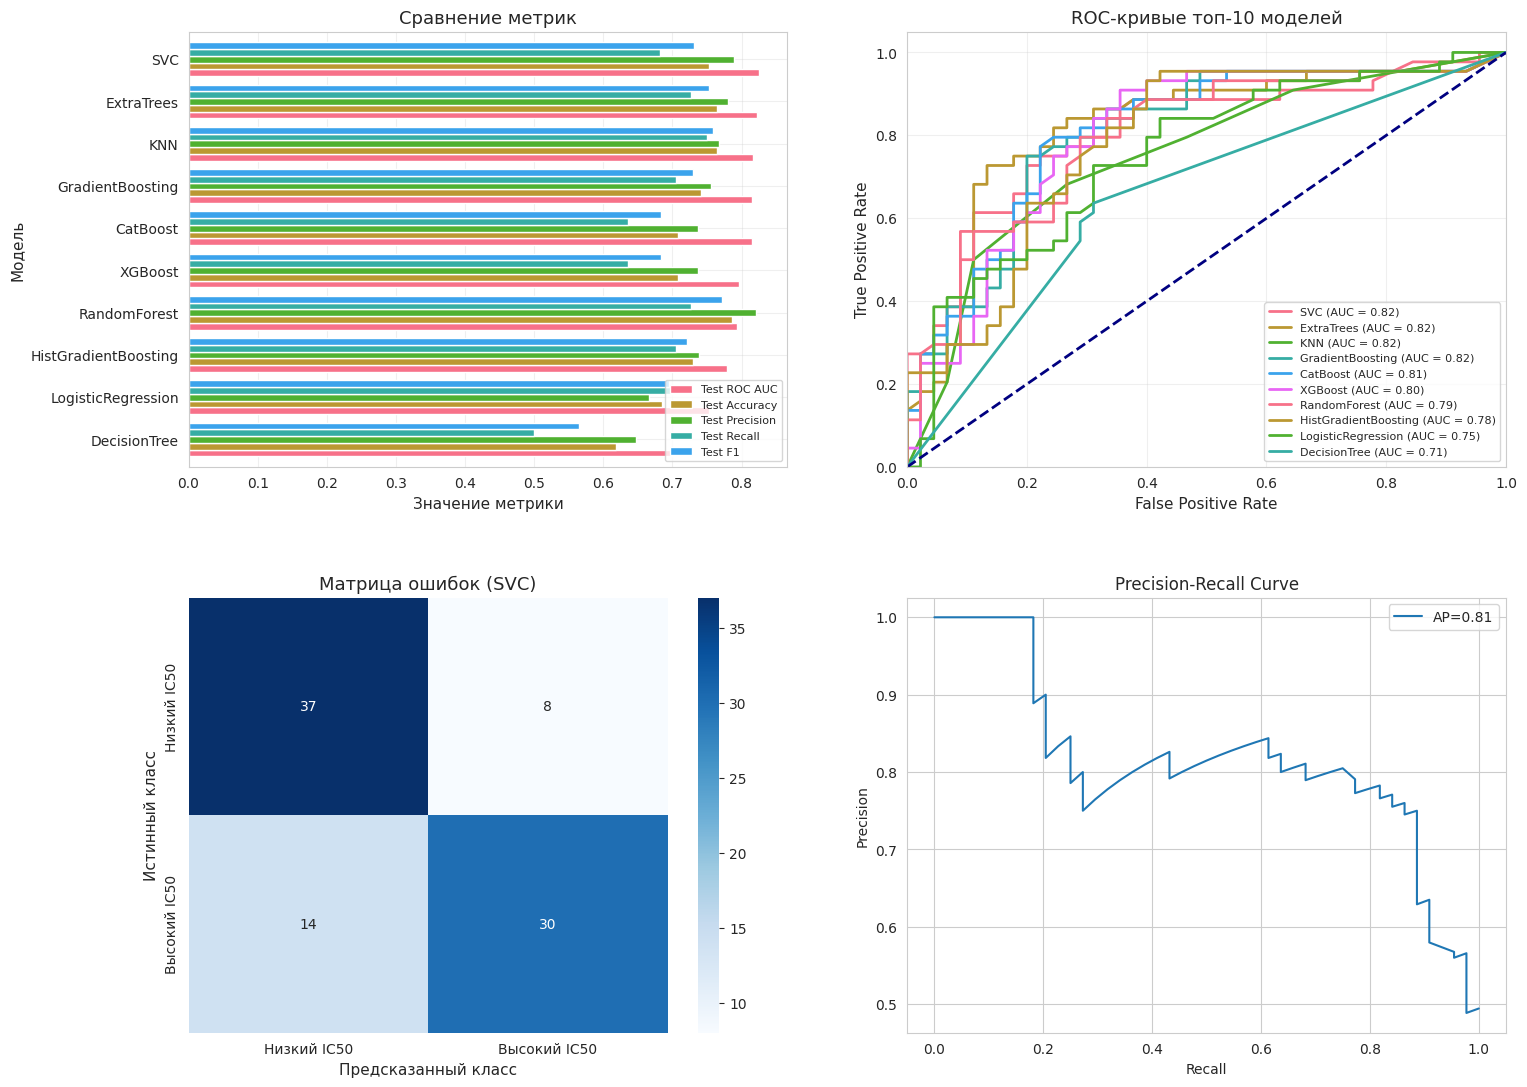

Модель SVC сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_svc.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_extratrees.pkl
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_knn.pkl
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_gradientboosting.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_catboost.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_metrics.csv


In [21]:
# @title Тест моделей на даннык, масштабированных PCA
# инициализация
evaluator_2 = ClassificationModelEvaluator(                     # ПОМЕНЯТЬ ТУТ!
    df=df_2,                                                    # ПОМЕНЯТЬ ТУТ!
    base_parameter=base_parameter,
    metod_name=metod_name_2,                                    # ПОМЕНЯТЬ ТУТ!
    analyse_name=analyse_name
    )
results = evaluator_2.evaluate_models(verbose=True)             # ПОМЕНЯТЬ ТУТ!
results_2 = results.copy()                                      # ПОМЕНЯТЬ ТУТ!

# Диаграмки
visualizer = ClassificationResultsVisualizer(
    evaluator_2,                                                # ПОМЕНЯТЬ ТУТ!
    results_df = results_2                                      # ПОМЕНЯТЬ ТУТ!
    )
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_2.save_top_models(n=5)                  # ПОМЕНЯТЬ ТУТ!

In [22]:
results_2.head(5)

,Metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,
SVC,pca,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",0.777130,0.752809,0.789474,0.681818,0.731707,0.825000,"[[37, 8], [14, 30]]","{'0': {'precision': 0.7254901960784313, 'recal..."
ExtraTrees,pca,"{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.782630,0.764045,0.780488,0.727273,0.752941,0.822980,"[[36, 9], [12, 32]]","{'0': {'precision': 0.75, 'recall': 0.8, 'f1-s..."
KNN,pca,"{'kneighborsclassifier__n_neighbors': 12, 'kne...",0.782062,0.764045,0.767442,0.750000,0.758621,0.815909,"[[35, 10], [11, 33]]","{'0': {'precision': 0.7608695652173914, 'recal..."
GradientBoosting,pca,"{'learning_rate': 0.2, 'max_depth': 7, 'min_sa...",0.767019,0.741573,0.756098,0.704545,0.729412,0.815404,"[[35, 10], [13, 31]]","{'0': {'precision': 0.7291666666666666, 'recal..."
CatBoost,pca,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",0.781182,0.707865,0.736842,0.636364,0.682927,0.814899,"[[35, 10], [16, 28]]","{'0': {'precision': 0.6862745098039216, 'recal..."


Подбор параметров LogisticRegression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
выполнено: Test ROC AUC: 0.597
Подбор параметров SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
выполнено: Test ROC AUC: 0.753
Подбор параметров KNN...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
выполнено: Test ROC AUC: 0.795
Подбор параметров DecisionTree...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.657
Подбор параметров RandomForest...
Fitting 3 folds for each of 126 candidates, totalling 378 fits
выполнено: Test ROC AUC: 0.764
Подбор параметров ExtraTrees...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.786
Подбор параметров GradientBoosting...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
выполнено: Test ROC AUC: 0.721
Подбор параметров HistGradientBoosting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
выполнено: Test 

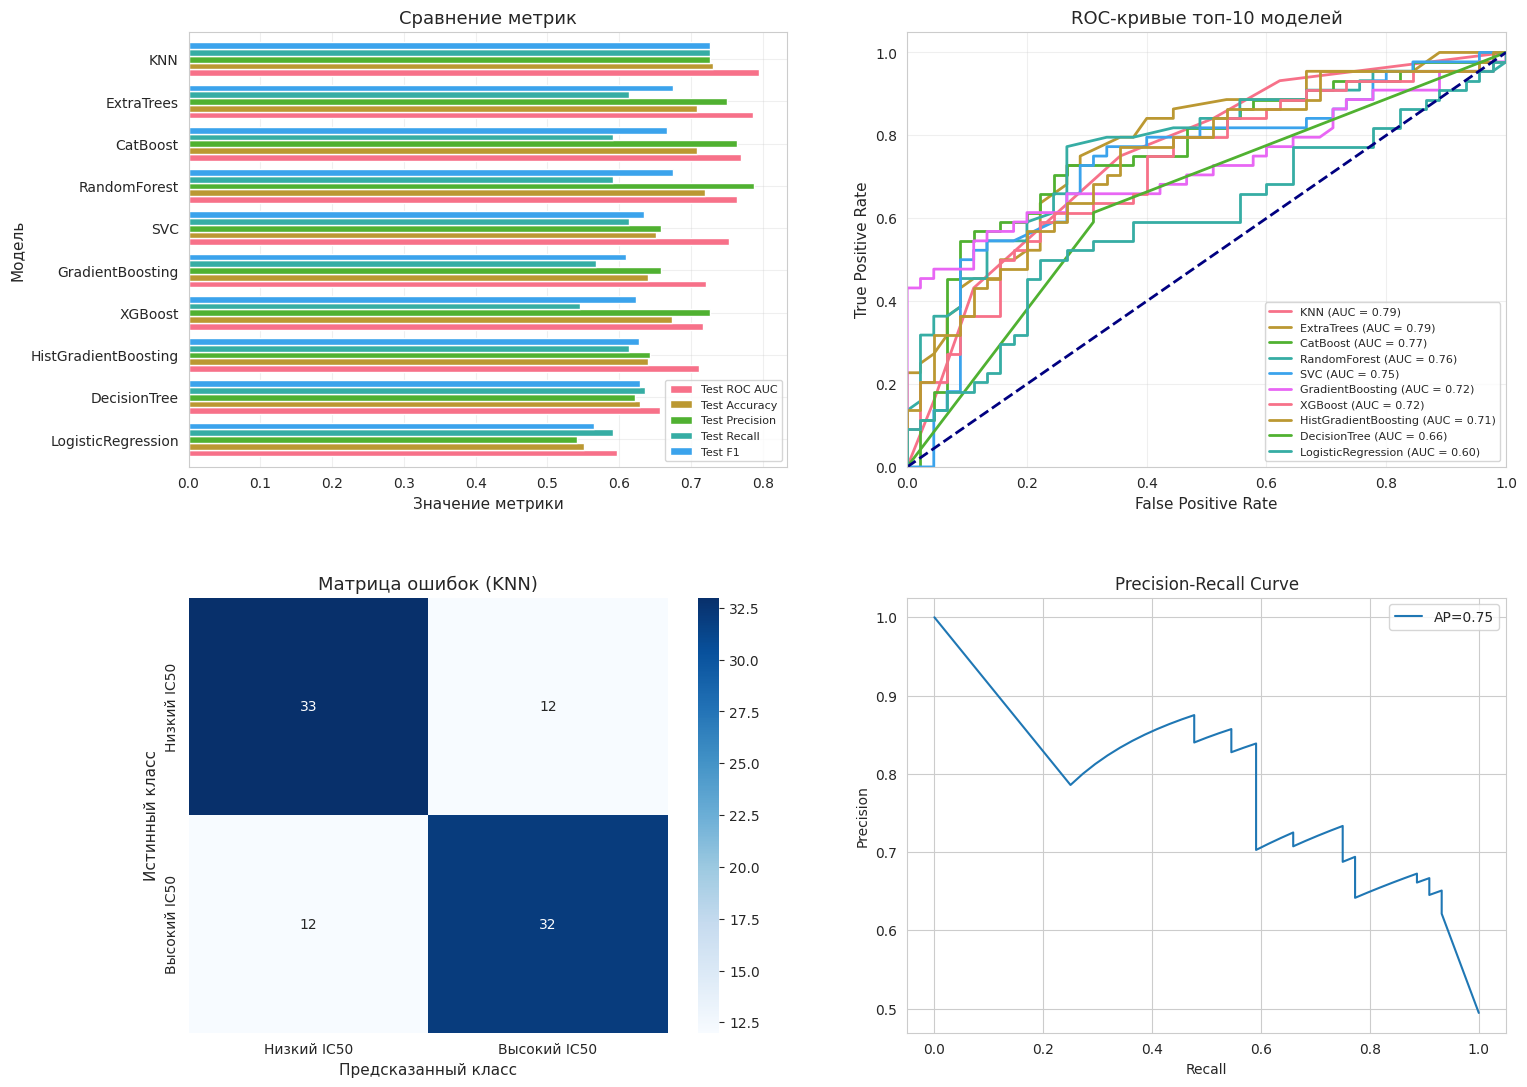

Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_tsne_knn.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_tsne_extratrees.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_tsne_catboost.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_tsne_randomforest.pkl
Модель SVC сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_tsne_svc.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_tsne_metrics.csv


In [23]:
# @title Тест моделей на даннык, масштабированных tSNE
# инициализация
evaluator_3 = ClassificationModelEvaluator(                     # ПОМЕНЯТЬ ТУТ!
    df=df_3,                                                    # ПОМЕНЯТЬ ТУТ!
    base_parameter=base_parameter,
    metod_name=metod_name_3,                                    # ПОМЕНЯТЬ ТУТ!
    analyse_name=analyse_name
    )
results = evaluator_3.evaluate_models(verbose=True)             # ПОМЕНЯТЬ ТУТ!
results_3 = results.copy()                                      # ПОМЕНЯТЬ ТУТ!

# Диаграмки
visualizer = ClassificationResultsVisualizer(
    evaluator_3,                                                # ПОМЕНЯТЬ ТУТ!
    results_df = results_3                                      # ПОМЕНЯТЬ ТУТ!
    )
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_3.save_top_models(n=5)                  # ПОМЕНЯТЬ ТУТ!

In [24]:
results_3.head(5)

,Metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,
KNN,tsne,"{'kneighborsclassifier__n_neighbors': 4, 'knei...",0.745726,0.730337,0.727273,0.727273,0.727273,0.794697,"[[33, 12], [12, 32]]","{'0': {'precision': 0.7333333333333333, 'recal..."
ExtraTrees,tsne,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.719685,0.707865,0.750000,0.613636,0.675000,0.786364,"[[36, 9], [17, 27]]","{'0': {'precision': 0.6792452830188679, 'recal..."
CatBoost,tsne,"{'depth': 10, 'iterations': 200, 'l2_leaf_reg'...",0.702510,0.707865,0.764706,0.590909,0.666667,0.770202,"[[37, 8], [18, 26]]","{'0': {'precision': 0.6727272727272727, 'recal..."
RandomForest,tsne,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.710256,0.719101,0.787879,0.590909,0.675325,0.763636,"[[38, 7], [18, 26]]","{'0': {'precision': 0.6785714285714286, 'recal..."
SVC,tsne,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",0.661420,0.651685,0.658537,0.613636,0.635294,0.753030,"[[31, 14], [17, 27]]","{'0': {'precision': 0.6458333333333334, 'recal..."


Подбор параметров LogisticRegression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
выполнено: Test ROC AUC: 0.596
Подбор параметров SVC...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
выполнено: Test ROC AUC: 0.724
Подбор параметров KNN...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
выполнено: Test ROC AUC: 0.746
Подбор параметров DecisionTree...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.659
Подбор параметров RandomForest...
Fitting 3 folds for each of 126 candidates, totalling 378 fits
выполнено: Test ROC AUC: 0.766
Подбор параметров ExtraTrees...
Fitting 3 folds for each of 63 candidates, totalling 189 fits
выполнено: Test ROC AUC: 0.767
Подбор параметров GradientBoosting...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
выполнено: Test ROC AUC: 0.743
Подбор параметров HistGradientBoosting...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
выполнено: Test 

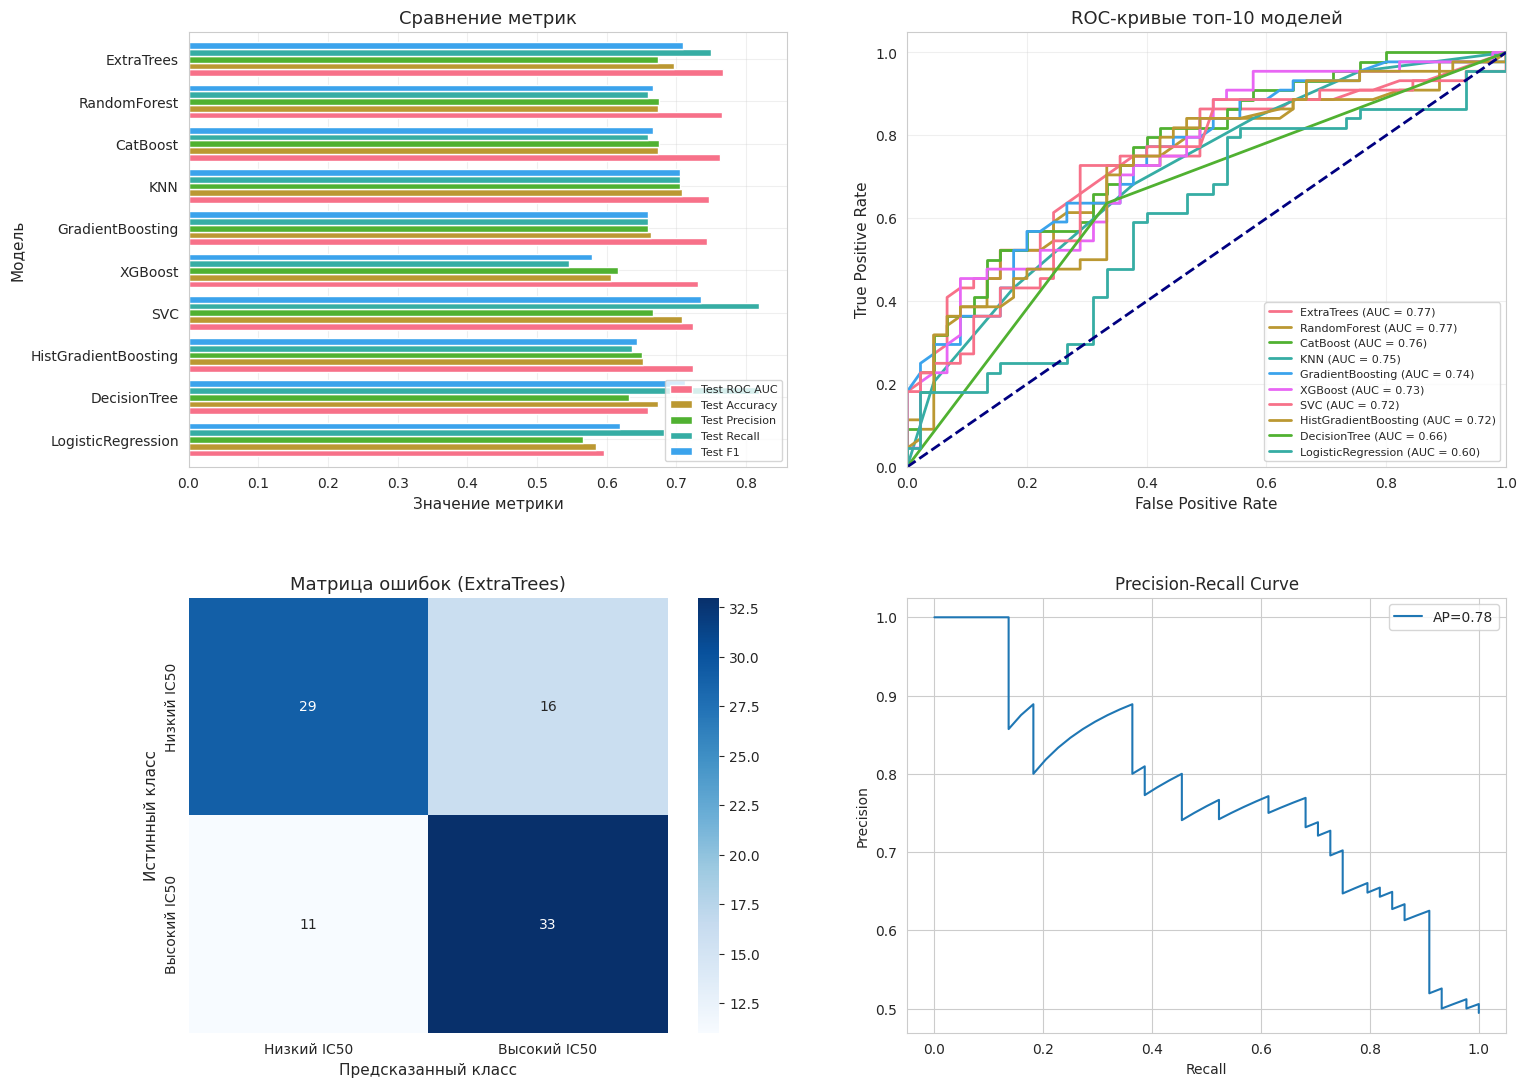

Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_umap_extratrees.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_umap_randomforest.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_umap_catboost.pkl
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_umap_knn.pkl
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_umap_gradientboosting.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_umap_metrics.csv


In [25]:
# @title Тест моделей на даннык, масштабированных UMAP
# инициализация
evaluator_4 = ClassificationModelEvaluator(                     # ПОМЕНЯТЬ ТУТ!
    df=df_4,                                                    # ПОМЕНЯТЬ ТУТ!
    base_parameter=base_parameter,
    metod_name=metod_name_4,                                    # ПОМЕНЯТЬ ТУТ!
    analyse_name=analyse_name
    )
results = evaluator_4.evaluate_models(verbose=True)             # ПОМЕНЯТЬ ТУТ!
results_4 = results.copy()                                      # ПОМЕНЯТЬ ТУТ!

# Диаграмки
visualizer = ClassificationResultsVisualizer(
    evaluator_4,                                                # ПОМЕНЯТЬ ТУТ!
    results_df = results_4                                      # ПОМЕНЯТЬ ТУТ!
    )
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_4.save_top_models(n=5)                  # ПОМЕНЯТЬ ТУТ!

In [26]:
results_4.head(5)

,Metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,
ExtraTrees,umap,"{'max_depth': None, 'min_samples_split': 10, '...",0.745236,0.696629,0.673469,0.750000,0.709677,0.767172,"[[29, 16], [11, 33]]","{'0': {'precision': 0.725, 'recall': 0.6444444..."
RandomForest,umap,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.740196,0.674157,0.674419,0.659091,0.666667,0.765657,"[[31, 14], [15, 29]]","{'0': {'precision': 0.6739130434782609, 'recal..."
CatBoost,umap,"{'depth': 10, 'iterations': 100, 'l2_leaf_reg'...",0.741056,0.674157,0.674419,0.659091,0.666667,0.762121,"[[31, 14], [15, 29]]","{'0': {'precision': 0.6739130434782609, 'recal..."
KNN,umap,"{'kneighborsclassifier__n_neighbors': 8, 'knei...",0.737258,0.707865,0.704545,0.704545,0.704545,0.745960,"[[32, 13], [13, 31]]","{'0': {'precision': 0.7111111111111111, 'recal..."
GradientBoosting,umap,"{'learning_rate': 0.1, 'max_depth': 20, 'min_s...",0.707585,0.662921,0.659091,0.659091,0.659091,0.743182,"[[30, 15], [15, 29]]","{'0': {'precision': 0.6666666666666666, 'recal..."


# СВОД И ВЫВОДЫ

In [27]:
# @title Датасет с результатами всех моделей на валидационной выборке
# Список файлов с результатами
result_files = [table_1, table_2, table_3, table_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем столбец с типом данных (из имени файла)
    data_type = file.split('_')[1]  # Извлекаем 'handmade', 'pca', 'tsne', 'umap'
    df['Data_Type'] = data_type

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
combined_results = pd.concat(dfs, ignore_index=True)

# Сохраняем объединенный результат
combined_results.to_csv(os.path.join(data_dir, csv_file_final), index=False)

# Выводим первые строки для проверки
combined_results_for_view=combined_results.drop(['Best Parameters'], axis = 1)
combined_results_for_view = combined_results_for_view.sort_values(by='Test ROC AUC', ascending=False)
combined_results_for_view.head(5)

,Model,Metod,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report,Data_Type
10,SVC,pca,0.777130,0.752809,0.789474,0.681818,0.731707,0.825000,[[37 8]\n [14 30]],"{'0': {'precision': 0.7254901960784313, 'recal...",CC50
11,ExtraTrees,pca,0.782630,0.764045,0.780488,0.727273,0.752941,0.822980,[[36 9]\n [12 32]],"{'0': {'precision': 0.75, 'recall': 0.8, 'f1-s...",CC50
12,KNN,pca,0.782062,0.764045,0.767442,0.750000,0.758621,0.815909,[[35 10]\n [11 33]],"{'0': {'precision': 0.7608695652173914, 'recal...",CC50
13,GradientBoosting,pca,0.767019,0.741573,0.756098,0.704545,0.729412,0.815404,[[35 10]\n [13 31]],"{'0': {'precision': 0.7291666666666666, 'recal...",CC50
14,CatBoost,pca,0.781182,0.707865,0.736842,0.636364,0.682927,0.814899,[[35 10]\n [16 28]],"{'0': {'precision': 0.6862745098039216, 'recal...",CC50


In [28]:
# @title вытащим гиперпарамаетры выбранной модели
filtered_row = combined_results[(combined_results['Model'] == "ExtraTrees") & (combined_results['Metod'] == "pca")]
value = filtered_row.iloc[0]['Best Parameters']
value

"{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}"

Подбор параметров SVC...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
выполнено: Test ROC AUC: 0.825
Подбор параметров KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
выполнено: Test ROC AUC: 0.794
Подбор параметров ExtraTrees...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
выполнено: Test ROC AUC: 0.834
Подбор параметров Voting_SVC_KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.77246596 0.77081166 0.76571173]
  warnings.warn(


выполнено: Test ROC AUC: 0.813
Подбор параметров Stacking_SVC_KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
выполнено: Test ROC AUC: 0.783
Подбор параметров Voting_SVC_ExtraTrees...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.774675   0.77228105 0.77383794]
  warnings.warn(


выполнено: Test ROC AUC: 0.819
Подбор параметров Stacking_SVC_ExtraTrees...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
выполнено: Test ROC AUC: 0.761
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_CC50_class2_pca_tuning.csv


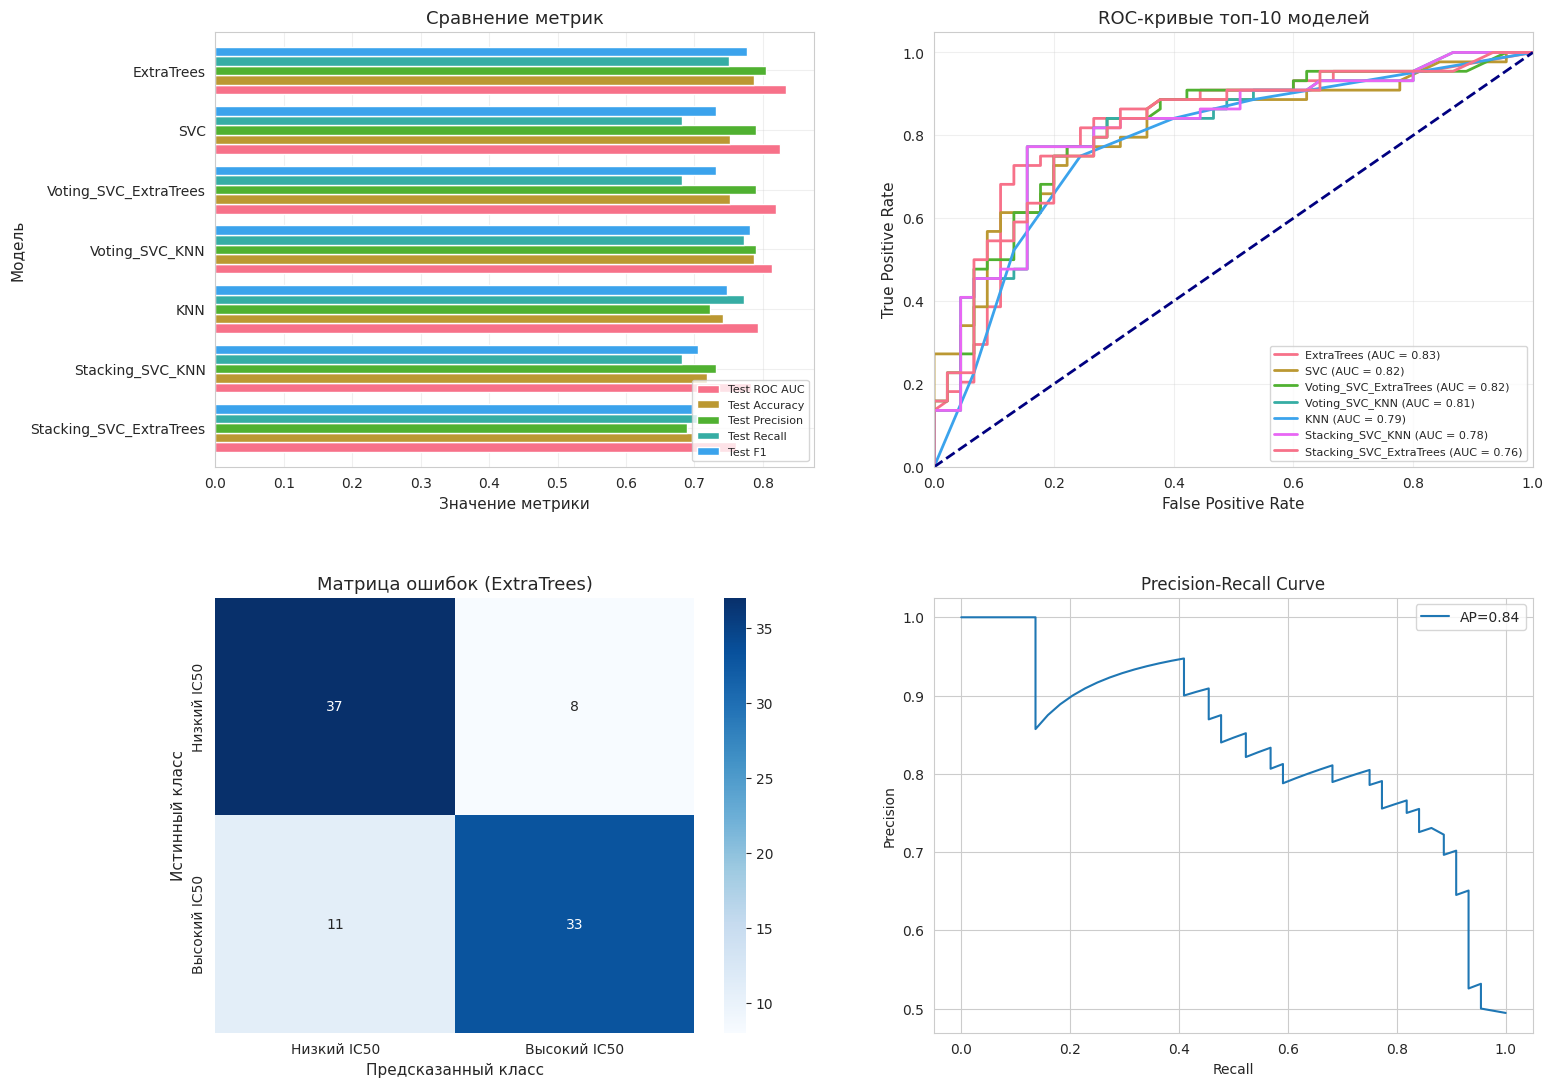

Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_tuning_extratrees.pkl
Модель SVC сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_tuning_svc.pkl
Модель Voting_SVC_ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_tuning_voting_svc_extratrees.pkl
Модель Voting_SVC_KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_tuning_voting_svc_knn.pkl
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_tuning_knn.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/CC50_class2_pca_tuning_metrics.csv


In [30]:
# @title ТЮНИНГ ТОП 3 МОДЕЛЕЙ и ОРКЕСТРЫ
random_state=42
from sklearn.ensemble import VotingClassifier, StackingClassifier


# подготовка данных для handmade
metod_name_tuning = 'pca_tuning'
base_name_tuning = f"{base_parameter}_{analyse_name}_{metod_name_tuning}"
table_tuning = f"table_{base_name_tuning}.csv"
final_tuning = f"{base_name_tuning}_"



# модели и гиперпараметры
models_tuning = {
    'SVC': {
        'model': make_pipeline(
            StandardScaler(),
            SVC(probability=True, random_state=42)
        ),
        'params': {
            'svc__C': [10, 50, 100],
            'svc__kernel': ['rbf'],
            'svc__gamma': ['scale']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [11, 12, 13],
            'weights': ['uniform', 'distance'],
            'p': [1]
        }
    },
    'ExtraTrees': {
                'model': ExtraTreesClassifier(random_state=random_state),
                'params': {
                    'n_estimators': [50, 75, 100, 125, 150],
                    'max_depth': [8, 10, 12, 14],
                    'min_samples_split': [8, 10, 12, 14, 16],
                }
            },
    # Ансамбли
    'Voting_SVC_KNN': {
        'model': VotingClassifier(
            estimators=[
                ('svc', make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))),
                ('knn', KNeighborsClassifier())
            ],
            voting='soft'
        ),
        'params': {
            'voting': ['hard', 'soft'],
            'weights': [[1, 1], [0.7, 0.3], [0.3, 0.7]]
        }
    },

    'Stacking_SVC_KNN': {
        'model': StackingClassifier(
            estimators=[
                ('svc', make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))),
                ('knn', KNeighborsClassifier())
            ],
            final_estimator=LogisticRegression(),
            cv=5
        ),
        'params': {
            'final_estimator__C': [0.1, 1, 10],
            'passthrough': [True, False]
        }
    },
    'Voting_SVC_ExtraTrees': {
        'model': VotingClassifier(
            estimators=[
                ('svc', make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))),
                ('et', ExtraTreesClassifier(random_state=random_state))
            ],
            voting='soft'
        ),
        'params': {
            'voting': ['hard', 'soft'],
            'weights': [[1, 1], [0.7, 0.3], [0.3, 0.7]]
        }
    },

    'Stacking_SVC_ExtraTrees': {
        'model': StackingClassifier(
            estimators=[
                ('svc', make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))),
                ('et', ExtraTreesClassifier(random_state=random_state))
            ],
            final_estimator=LogisticRegression(),
            cv=5
        ),
        'params': {
            'final_estimator__C': [0.1, 1, 10],
            'passthrough': [True, False]
        }
    }
}




evaluator_tuning = ClassificationModelEvaluator(                     # ПОМЕНЯТЬ ТУТ!
    df=df_2,                                                    # ПОМЕНЯТЬ ТУТ!
    base_parameter=base_parameter,
    metod_name=metod_name_tuning,                                    # ПОМЕНЯТЬ ТУТ!
    analyse_name=analyse_name,
    models_config=models_tuning
    )
results = evaluator_tuning.evaluate_models(verbose=True)             # ПОМЕНЯТЬ ТУТ!
results_tuning = results.copy()                                      # ПОМЕНЯТЬ ТУТ!

# Диаграмки
visualizer = ClassificationResultsVisualizer(
    evaluator_tuning,                                                # ПОМЕНЯТЬ ТУТ!
    results_df = results_tuning                                      # ПОМЕНЯТЬ ТУТ!
    )
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_tuning.save_top_models(n=5)                  # ПОМЕНЯТЬ ТУТ!

In [31]:
results_tuning

,Metod,Best Parameters,CV ROC AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC AUC,Confusion Matrix,Classification Report
Model,,,,,,,,,,
ExtraTrees,pca_tuning,"{'max_depth': 10, 'min_samples_split': 12, 'n_...",0.786554,0.786517,0.804878,0.750000,0.776471,0.833586,"[[37, 8], [11, 33]]","{'0': {'precision': 0.7708333333333334, 'recal..."
SVC,pca_tuning,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",0.777130,0.752809,0.789474,0.681818,0.731707,0.825000,"[[37, 8], [14, 30]]","{'0': {'precision': 0.7254901960784313, 'recal..."
Voting_SVC_ExtraTrees,pca_tuning,"{'voting': 'soft', 'weights': [1, 1]}",0.774675,0.752809,0.789474,0.681818,0.731707,0.819444,"[[37, 8], [14, 30]]","{'0': {'precision': 0.7254901960784313, 'recal..."
Voting_SVC_KNN,pca_tuning,"{'voting': 'soft', 'weights': [1, 1]}",0.772466,0.786517,0.790698,0.772727,0.781609,0.812879,"[[36, 9], [10, 34]]","{'0': {'precision': 0.782608695652174, 'recall..."
KNN,pca_tuning,"{'n_neighbors': 11, 'p': 1, 'weights': 'distan...",0.779309,0.741573,0.723404,0.772727,0.747253,0.793687,"[[32, 13], [10, 34]]","{'0': {'precision': 0.7619047619047619, 'recal..."
Stacking_SVC_KNN,pca_tuning,"{'final_estimator__C': 0.1, 'passthrough': True}",0.778410,0.719101,0.731707,0.681818,0.705882,0.782576,"[[34, 11], [14, 30]]","{'0': {'precision': 0.7083333333333334, 'recal..."
Stacking_SVC_ExtraTrees,pca_tuning,"{'final_estimator__C': 1, 'passthrough': True}",0.780084,0.696629,0.688889,0.704545,0.696629,0.760859,"[[31, 14], [13, 31]]","{'0': {'precision': 0.7045454545454546, 'recal..."
